In [1]:
#make it possible to import EPDF stuff
import sys
sys.path.insert(0,'../')


### %reload_ext autoreload

%reset

import numpy as np

import scipy.interpolate
from scipy.stats import poisson
from scipy.stats import uniform
from astropy import units

import matplotlib.pyplot as pl
import matplotlib

import healpy as hp


import pdb
import time

import LFI_binned as epdfabc
import subhalos as subs
import FermiBackgrounds
import DMsignal

import pickle as pk

#matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode'] = True

import abc_funcs as af


%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
#For low Mmin at true galactocentric distance
if (0):
    fft_type = 'fast'
    physics_type = 'baseline'
    physics_settings, obs_settings, fft_settings = subs.get_settings(fft_type = fft_type,\
                                                                     physics_type = physics_type)
    # get rid of M dependence for sigma
    physics_settings['lum_model'] = 'C0-simplified'
#For low Mmin at galactic center
if (0):
    fft_type = 'fast_isotropic'
    physics_type = 'isotropic'
    physics_settings, obs_settings, fft_settings = subs.get_settings(fft_type =  fft_type, \
                                                                     physics_type = physics_type)
    # get rid of M dependence for sigma
    #physics_settings['lum_model'] = 'C0-simplified'
#For high Mmin at galactic center
if (1):
    fft_type = 'highMmin_iso'
    physics_type = 'highMmin_iso'    
    physics_settings, obs_settings, fft_settings = subs.get_settings(fft_type = fft_type,
                                                                    physics_type = physics_type)

print(obs_settings)
print(physics_settings)
print(fft_settings)

{'area': 2000.0, 'obs_time': 100.0, 'fov_factor': 0.2, 'Omega_pixel': 0.00025566346464760684, 'psi': 1.7453292519943295}
{'R_G': 220, 'd_sun': 0.001, 'M_max': 10000000000.0, 'M_min': 1000.0, 'PhiPP': 1.0, 'n': 0, 'beta': 1.9, 'lum_model': 'C0-simplified', 'l_min': 0.001}
{'minF': 1e-16, 'maxF': 100000.0, 'numF': 8192, 'minlnk': -6.907755278982137, 'maxlnk': 15.424948470398373, 'numk': 8192, 'minf_out': 5e-07, 'maxf_out': 0.0009, 'numf_out': 8192, 'minf_pc': 5e-07, 'maxf_pc': 0.0009}


In [3]:
exposure = obs_settings['area']*obs_settings['obs_time']*obs_settings['fov_factor']

done with 0.0 of p1f calculation
done with 0.1 of p1f calculation
done with 0.2 of p1f calculation
done with 0.3 of p1f calculation
done with 0.4 of p1f calculation
done with 0.5 of p1f calculation
done with 0.6 of p1f calculation
done with 0.7 of p1f calculation
done with 0.8 of p1f calculation
done with 0.9 of p1f calculation


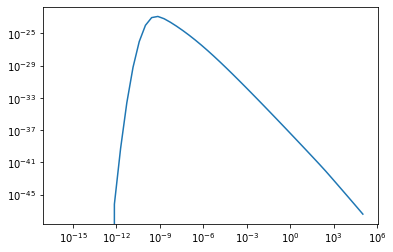

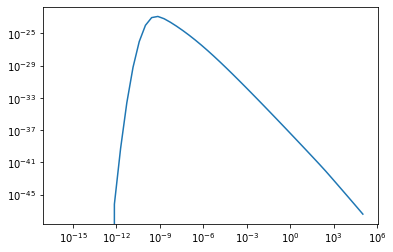

In [11]:
# Compute P_1(F)
#flux in photons/cm^2/yr
f_p1f = np.exp(np.linspace(np.log(1e-16), np.log(100000.0)))
p1f = subs.p_1_f(f_p1f, physics_settings, obs_settings)

fig, ax = pl.subplots(1,1)
ax.plot(f_p1f, p1f)
ax.set_xscale('log')
ax.set_yscale('log')

In [4]:
# Calculate mu
mu_test = subs.get_mu(physics_settings, obs_settings)
print("mu = ", mu_test)


#do calculation directly
num_M = 10000
num_ell = 2000
settings = physics_settings
Omega_pixel = obs_settings['Omega_pixel']
psi = obs_settings['psi']
M_min = settings['M_min']
M_max = settings['M_max']
beta = settings['beta']
d_sun = settings['d_sun']
R_G = settings['R_G']
l_min = settings['l_min']
l_max = d_sun*(np.cos(psi)  + np.sqrt(-np.sin(psi)**2. + (R_G/d_sun)**2.)) 
ll = np.exp(np.linspace(np.log(l_min), np.log(l_max), num = num_ell))
rad = np.sqrt(ll**2. + d_sun**2. - 2.*ll*d_sun*np.cos(psi))
dl = ll[1:] - ll[:-1]
l_integrand = np.zeros(len(ll))
for li in range(0, len(ll)):
    M_min_integrate = M_min #M_sun
    M_max_integrate = M_max #M_sun
    MM = np.exp(np.linspace(np.log(M_min_integrate), np.log(M_max_integrate), num = num_M))
    dM = MM[1:] - MM[:-1]
    dNdM = subs.mass_function(settings, MM, rad[li]) #1/Msun/kpc^3
    l_integrand[li] = (ll[li]**2.)*np.sum(0.5*dM*(dNdM[1:] + dNdM[:-1])) #1/kpc
mu = Omega_pixel*np.sum(0.5*dl*(l_integrand[1:] + l_integrand[:-1]))
print("mu v2 = ", mu)
#print(l_integrand)
print("d_sun = ", d_sun)
print("should be one if using Nside = 64: ", Omega_pixel*12*64**2./(4.*np.pi))
print("psi = ", psi)
print("Mmin = ", M_min)
print("Mmax = ", M_max)
#print("ll = ", ll)

mu =  96.073376038219
mu v2 =  96.13965489794394
d_sun =  0.001
should be one if using Nside = 64:  1.0
psi =  1.7453292519943295
Mmin =  1000.0
Mmax =  10000000000.0


mu =  96.073376038219
done with 0.0 of p1f calculation
done with 0.0999755859375 of p1f calculation
done with 0.199951171875 of p1f calculation
done with 0.2999267578125 of p1f calculation
done with 0.39990234375 of p1f calculation
done with 0.4998779296875 of p1f calculation
done with 0.599853515625 of p1f calculation
done with 0.6998291015625 of p1f calculation
done with 0.7998046875 of p1f calculation
done with 0.8997802734375 of p1f calculation
done with 0.999755859375 of p1f calculation
p1f computed
mean pf =  2.8368439857681356
mean pc =  2.8368439857681373


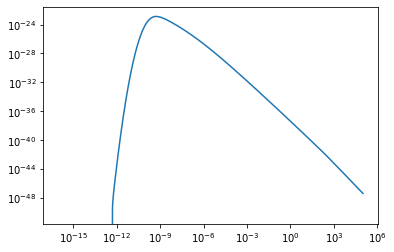

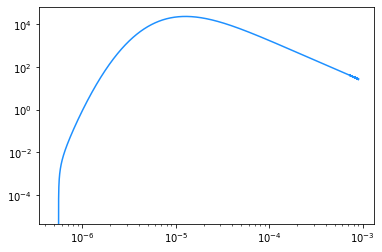

In [5]:
# Compute P(C) and P(F) - this will not apply extension, so expect P(C) to be wrong

maxc = 100.
counts = np.arange(0,maxc)
pc_incorrect, f_pf_precomputed, pf_pf_precomputed = subs.get_pc(counts, physics_settings, fft_settings, \
                                                             obs_settings, return_fpf = True)

integral =  1.0


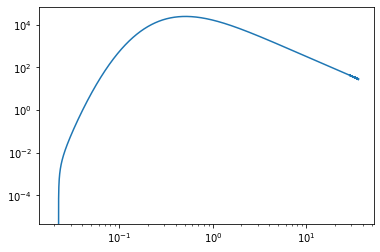

In [6]:
fig, ax = pl.subplots(1,1)
ax.plot(f_pf_precomputed*exposure, pf_pf_precomputed)
ax.set_xscale('log')
ax.set_yscale('log')

min_f = fft_settings['minf_out']
max_f = fft_settings['maxf_out']
    
good = np.where((f_pf_precomputed > min_f) & (f_pf_precomputed < max_f))[0]
pf_good = pf_pf_precomputed[good]
f_good = f_pf_precomputed[good]
df_good = f_good[1:] - f_good[:-1]

check_integral = np.sum(0.5*df_good*(pf_good[1:] + pf_good[:-1]))
print("integral = ", check_integral)

mean pf =  8.453037877285954
mean pc =  3.670647212663177


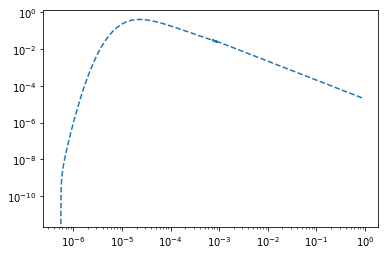

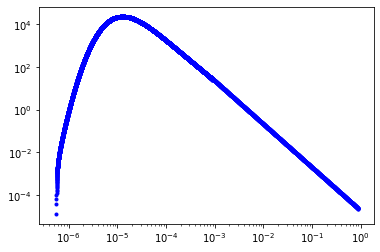

In [7]:
# Get pc by extending P(F)
pc, f_pf, pf_pf = subs.get_pc_fast(counts, f_good, pf_good, physics_settings, fft_settings, obs_settings, \
                 default_phipp = 1.0, do_extend = True, return_pf = True)

fig, ax = pl.subplots(1,1)
ax.plot(f_pf, pf_pf, 'b.')
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim((7.0e-4, 1.0e-3))

sum pc =  0.9913484057218183


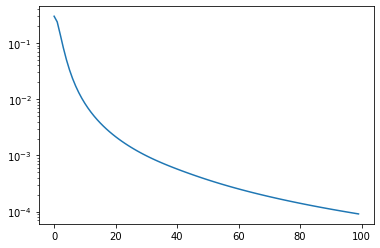

In [8]:
fig, ax = pl.subplots(1,1)
ax.plot(counts, pc)
#ax.set_xscale('log')
ax.set_yscale('log')
print("sum pc = ", np.sum(pc))


mean pf =  0.00021132594693214885
mean pf * exposure =  8.453037877285954
mean pc =  3.670647212663177


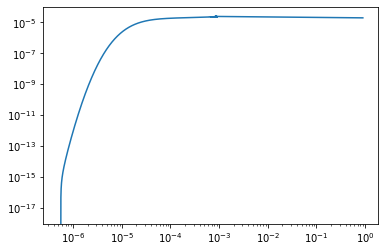

In [9]:
# Check that mean p1f * mu = mean(pf)

#P1(F)

#fig, ax = pl.subplots(1,1)
#ax.plot(f_p1f, p1f*f_p1f**2.)
#ax.set_xscale('log')
#ax.set_yscale('log')

#df = f_p1f[1:] - f_p1f[:-1]
#areap1 = np.sum(0.5*df*(p1f[1:] + p1f[:-1]))
#integrand = f_p1f*p1f/areap1
#mean_p1 = np.sum(0.5*df*(integrand[1:] + integrand[:-1]))
#print("mean p1 = ", mean_p1)
#print("mean p1 * mu = ", mean_p1*mu)

#P(F)
fig, ax = pl.subplots(1,1)
ax.plot(f_pf, pf_pf*f_pf**2.)
ax.set_xscale('log')
ax.set_yscale('log')

dfpf = f_pf[1:] - f_pf[:-1]
integrand = f_pf*pf_pf
mean_pf = np.sum(0.5*dfpf*(integrand[1:] + integrand[:-1]))
print("mean pf = ", mean_pf)

print("mean pf * exposure = ", mean_pf*exposure)

#P(c)
print("mean pc = ", np.sum(counts*pc))


In [12]:
save_pc = True
if save_pc:
    pf_data = {'maxc':maxc, 'pc':pc/np.sum(pc), 'counts':counts, 'f_pf_precomputed':f_pf_precomputed, \
               'pf_pf_precomputed':pf_pf_precomputed, \
               'f_p1f_cm2yr':f_p1f, 'p1f':p1f, \
               'physics_settings':physics_settings, 'fft_settings':fft_settings, 'obs_settings':obs_settings}
    pk.dump(pf_data, open('../data/Test_Data/pf_and_pc_for_test_Mmin' + str(physics_settings['M_min']) +\
                          '_phys' + physics_type + '_fft' + fft_type + \
                          '_withp1f_fixedcentermmin_highexp.pk','wb'))


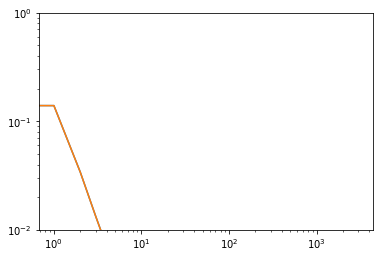

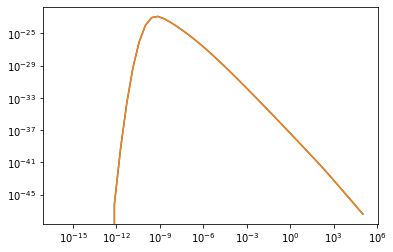

In [13]:
#compare res

file1 = 'pf_and_pc_for_test_Mmin1000.0_physhighMmin_iso_ffthighMmin_iso_withp1f_fixedcentermmin_hires.pk'
file2 = 'pf_and_pc_for_test_Mmin1000.0_physhighMmin_iso_ffthighMmin_iso_withp1f_fixedcentermmin_wide.pk'

dat1 = pk.load(open('../data/Test_Data/' + file1, 'rb'))
dat2 = pk.load(open('../data/Test_Data/' + file2, 'rb'))


fig, ax = pl.subplots(1,1)
ax.plot(dat1['pc'])
ax.plot(dat2['pc'])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim((0.01, 1.0))


fig, ax = pl.subplots(1,1)
ax.plot(dat1['f_p1f_cm2yr'], dat1['p1f'])
ax.plot(dat2['f_p1f_cm2yr'], dat2['p1f'])
ax.set_yscale('log')
ax.set_xscale('log')

In [14]:
print(dat1['pc'][0:10])
print(dat2['pc'][0:10])

[0.7849461  0.1394325  0.03411116 0.01340326 0.00706198 0.00435852
 0.00295022 0.0021213  0.00159324 0.00123757]
[0.78437124 0.13932421 0.034076   0.01338288 0.00704869 0.00435028
 0.00294527 0.00211819 0.00159104 0.00123586]


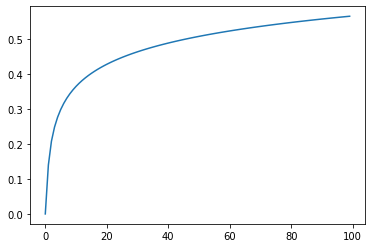

In [16]:
fig, ax = pl.subplots(1,1)
cc = dat1['counts']
pc = dat1['pc']
ax.plot(np.cumsum(cc*pc))